CBIR using HOG

TODO:
- return list of images (numbers or paths?)
- tweak some parameters?
- understand length 70308
- read more about HOG and understand it better
- create an unlabeled gallery of 10k images and query gallery of 100 images to simulate competition environment


14/05: 16m19s for query of unbalanced with CPU
       1h5m for gallery of unbalanced with CPU 

# Preworkout

In [1]:
#importing required libraries
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler  # To transform the dataset
from sklearn.cluster import KMeans                # To instantiate, train and use model
from sklearn import metrics    
from scipy import spatial
import numpy as np
from numpy import dot
from numpy.linalg import norm

import os
import os.path

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
!unzip -q /content/drive/MyDrive/datasets/unbalanced_dataset_2304.zip

In [5]:
GALLERY_PATH = "/content/unbalanced_dataset_2304/validation/gallery"
QUERY_PATH = "/content/unbalanced_dataset_2304/validation/query"


In [8]:
def get_features(PATH):
  query_features = [] # list with vectors of features (each with length = 70308)
  query_paths = [] # list with paths of the query images
  for classe in os.listdir(PATH):
    temp_path = os.path.join(PATH, classe)
    temp_images = os.listdir(temp_path) # lista di tutte le foto di quella cartella
    for img_name in temp_images[:2]:
      img_temp = os.path.join(temp_path, img_name)
      img = imread(img_temp, plugin = "matplotlib", as_gray = True) # plugin = matplotlib otherwise gives error when reading (corrupted files?)
      resized_img = resize(img, (128, 64)) # HOG accepts only these dimensions
      fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=True, multichannel=False)
    
      query_paths.append(img_temp)
      query_features.append(fd)
    #plt.imshow(hog_image, cmap="gray")
    #plt.show()
  query_features = np.array(query_features) 
  return query_features, query_paths

# Extract Features

Extracting the query features

In [11]:
query_features, query_paths = get_features(QUERY_PATH)
gallery_features, gallery_paths = get_features(GALLERY_PATH)

## Printing the query images

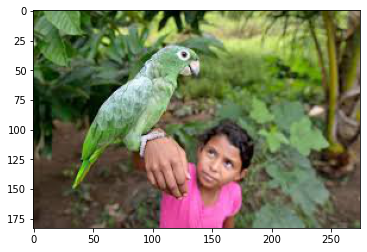

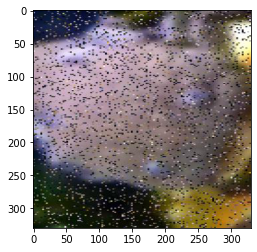

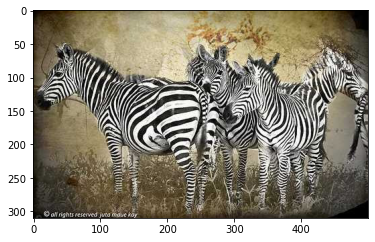

In [10]:
for q in query_paths[::100]:
  plt.imshow(mpimg.imread(q))
  plt.show()

## cluster gallery 

In [12]:
output_dim = 30
model = KMeans(n_clusters=output_dim, n_init=10, max_iter=5000, verbose=False)
model.fit(gallery_features)

KMeans(max_iter=5000, n_clusters=30, verbose=False)

In [13]:
pairwise_dist = spatial.distance.cdist(query_features, gallery_features, 'minkowski', p=2.)

print('--> Computed distances and got c-dist {}'.format(pairwise_dist.shape))

# we sort mathed indices
indices = np.argsort(pairwise_dist, axis=-1)

--> Computed distances and got c-dist (202, 202)


Calculating **euclidean distances** between query feature vectors and gallery feature vectors

In [17]:
def get_similars(query_features, gallery_features):
  similars = []
  for query_v in query_features[::22]:
      dists = np.linalg.norm(query_v - gallery_features, axis=1)  # L2 distances to features
      ids = np.argsort(dists)[:10]  # Top 10 results
      scores = [(dists[id], id ) for id in ids]
      similars.append(scores)
  return similars

In [28]:
def print_most_similar(similars, query_paths, i):
    
    plt.imshow(mpimg.imread(query_paths[::22][i]))

    plt.figure(figsize=(10,10))
    for j, imm in enumerate(similars[i]):
      plt.subplot(4,4,j+1)
      plt.imshow(mpimg.imread(gallery_paths[imm[1]]))

In [33]:
def print_hog(img_temp):

  img = imread(img_temp, plugin = "matplotlib", as_gray = True) # plugin = matplotlib otherwise gives error when reading (corrupted files?)
  resized_img = resize(img, (128, 64)) # HOG accepts only these dimensions
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8), # try and tweak some of these parameters!
                      cells_per_block=(2, 2), visualize=True, multichannel=False)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.imshow(resized_img, cmap=plt.cm.gray)
  ax1.set_title('Input image')

  ax2.imshow(hog_image, cmap=plt.cm.gray)
  ax2.set_title('Histogram of Oriented Gradients')
  plt.show()
  return hog_image


In [36]:
similars = get_similars(query_features, gallery_features)
   
#print_most_similar(similars, query_paths, 3 )   

In [37]:
#hog_image = print_hog("/content/unbalanced_dataset_2304/training/fox/5LDG5LC4JLJT.jpg")

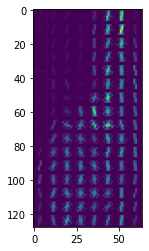

In [35]:
plt.imshow(hog_image)

Pros of HOG:
- There is no training involved since it is not deep learning

Limitations of HOG:
- time spent to calculate features: it is a fast algorithm (faster than SIFT), but it takes around 1h to calculate the features of all the gallery images, which is not ideal given the competition lasts 2h.
- it does not "learn" anything, but it is a simple mathematical algorithm on the pictures. This means that, for example, if the query image is a sketch of an animal with a white background, the most similar images returned by euclidean distance will most likely be with a white background (but not necessarily of the same animal!)